In [4]:
import pandas as pd
import glob
from tqdm import tqdm

In [9]:
# load all json files from processed_results/

all_files = glob.glob("processed_results/*.json")
li = []

for filename in all_files:
  df = pd.read_json(filename, lines=False)
  li.append(df)

In [10]:
df = pd.concat(li, axis=0, ignore_index=True)

In [14]:
stats_arrs = []

for i in range(len(df)):
  stats_arrs.append(df["statistics"][i])

In [17]:
# flatten
stats = [item for sublist in stats_arrs for item in sublist]

In [52]:
stats_df = pd.DataFrame(stats)
stats_df['is_best'] = stats_df['rank'] == 0

In [53]:
stats_df.head()

,logits_entropy,logits_varentropy,logits_skewness,logits_kurtosis,attn_entropy,attn_varentropy,attn_skewness,attn_kurtosis,agreement,interaction_strength,prob,rank,token,is_best
0,4.84375,25.750,0.271484,0.921875,2.359375,0.812500,-0.355469,-1.265625,0.032959,2.390625,0.000759,37,1,False
1,8.25000,32.500,-0.008850,0.531250,2.406250,0.808594,-0.392578,-1.156250,0.032715,2.406250,0.182617,0,.,True
2,10.50000,24.125,0.028076,0.296875,2.437500,0.812500,-0.367188,-1.164062,0.031250,2.453125,0.000002,-1,Innovative,False
3,9.18750,22.875,0.486328,0.625000,2.484375,0.816406,-0.371094,-1.132812,0.029785,2.453125,0.062988,2,\n,False
4,5.03125,20.875,0.314453,1.031250,2.453125,0.847656,-0.291016,-1.226562,0.029419,2.625000,0.170898,1,2,False


In [22]:
import plotnine as pn
import numpy as np

In [134]:
# -log(sqrt(varent)) / entropy
stats_df['normalized_varent'] = -stats_df['logits_varentropy'].apply(lambda x: -np.log(x ** 0.5) )
stats_df['normalized_varent'] = stats_df['normalized_varent'] / stats_df['logits_entropy']
stats_df['normalized_varent'] = stats_df['normalized_varent'].apply(lambda x: np.clip(x, -5, 5))

In [123]:
stats_df.head()

,logits_entropy,logits_varentropy,logits_skewness,logits_kurtosis,attn_entropy,attn_varentropy,attn_skewness,attn_kurtosis,agreement,interaction_strength,prob,rank,token,is_best,normalized_varent
0,4.84375,25.750,0.271484,0.921875,2.359375,0.812500,-0.355469,-1.265625,0.032959,2.390625,0.000759,37,1,False,0.335322
1,8.25000,32.500,-0.008850,0.531250,2.406250,0.808594,-0.392578,-1.156250,0.032715,2.406250,0.182617,0,.,True,0.210984
2,10.50000,24.125,0.028076,0.296875,2.437500,0.812500,-0.367188,-1.164062,0.031250,2.453125,0.000002,-1,Innovative,False,0.151583
3,9.18750,22.875,0.486328,0.625000,2.484375,0.816406,-0.371094,-1.132812,0.029785,2.453125,0.062988,2,\n,False,0.170343
4,5.03125,20.875,0.314453,1.031250,2.453125,0.847656,-0.291016,-1.226562,0.029419,2.625000,0.170898,1,2,False,0.301968


In [70]:
stats_df.sample(frac=0.1).assign(rank=lambda x: np.clip(x['rank'], 0, 100)).melt(id_vars=["is_best"], value_vars=["logits_entropy", "logits_varentropy"])

,is_best,variable,value
0,False,logits_entropy,1.062500
1,True,logits_entropy,0.640625
2,True,logits_entropy,1.312500
3,False,logits_entropy,4.093750
4,True,logits_entropy,0.033691
...,...,...,...
328447,True,logits_varentropy,8.125000
328448,False,logits_varentropy,5.875000
328449,False,logits_varentropy,9.812500
328450,True,logits_varentropy,16.125000


/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 403 rows containing missing values.


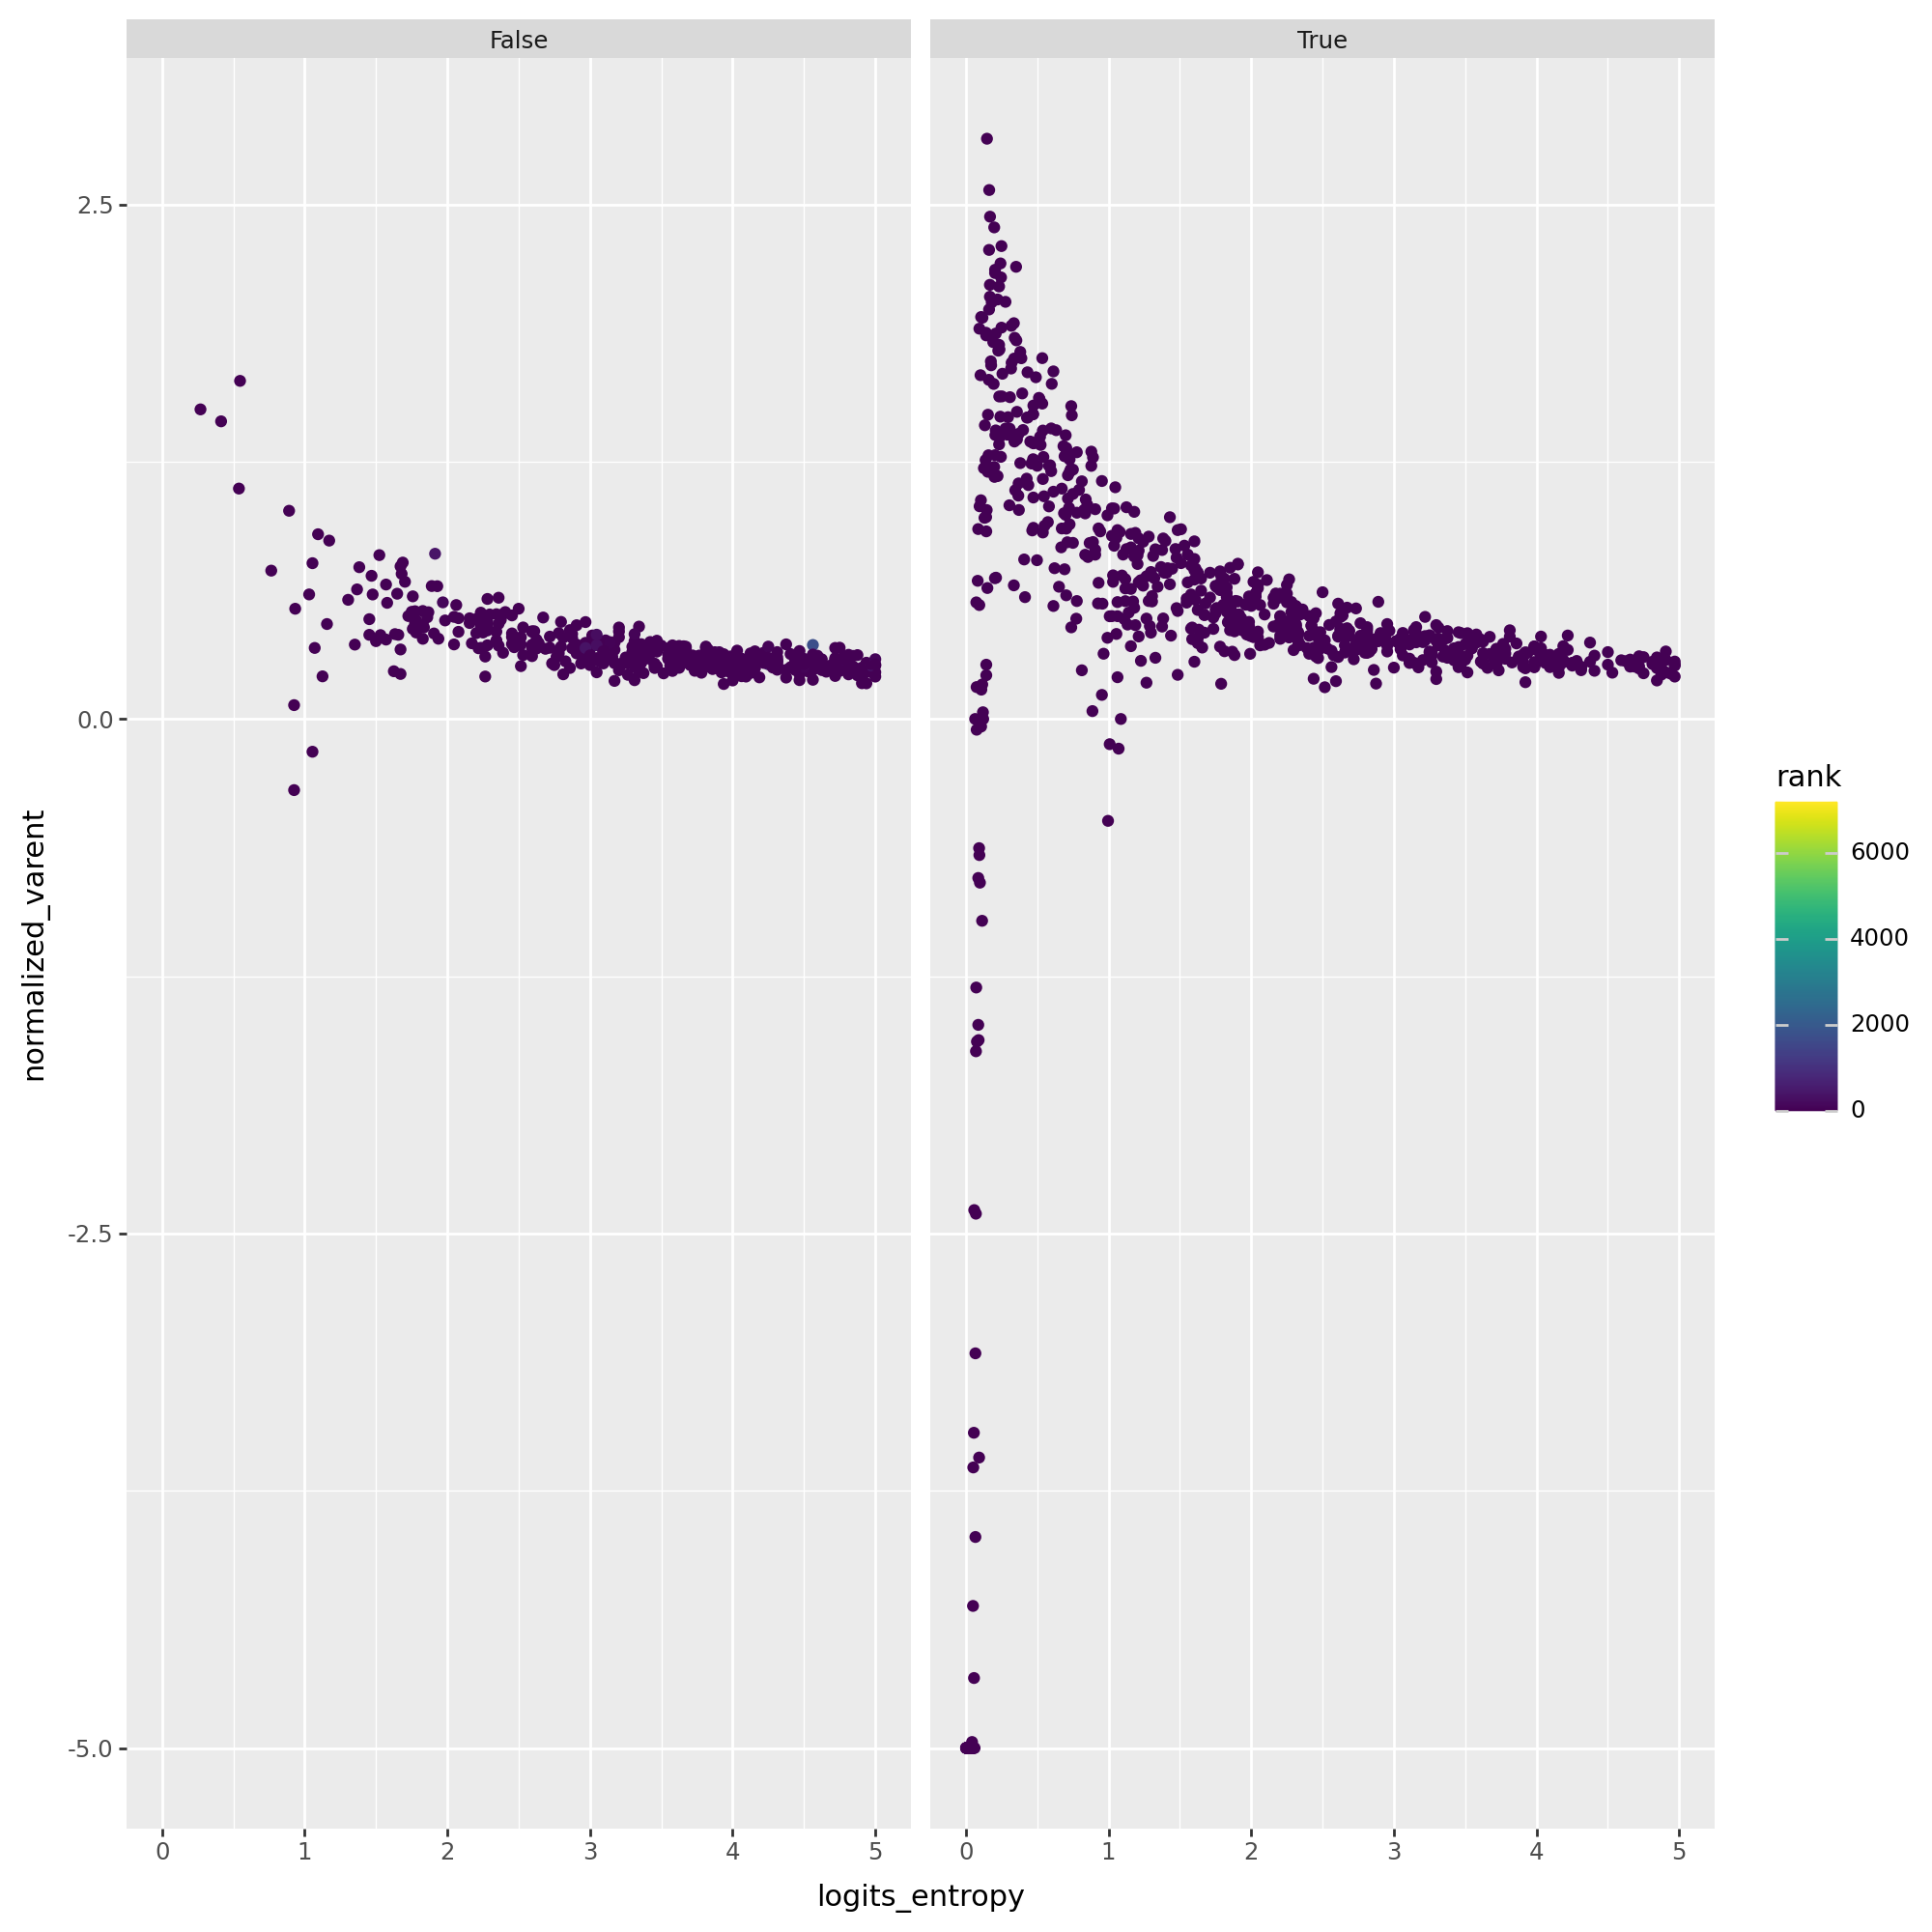

In [140]:
(
  pn.ggplot(
    stats_df.sample(frac=.001), pn.aes(x="logits_entropy", y="normalized_varent", color="rank")
  )
  + pn.geom_point()
  + pn.facet_wrap("~is_best")
  + pn.scale_x_continuous(limits=(0, 5))
  + pn.theme(figure_size=(10, 10))
)

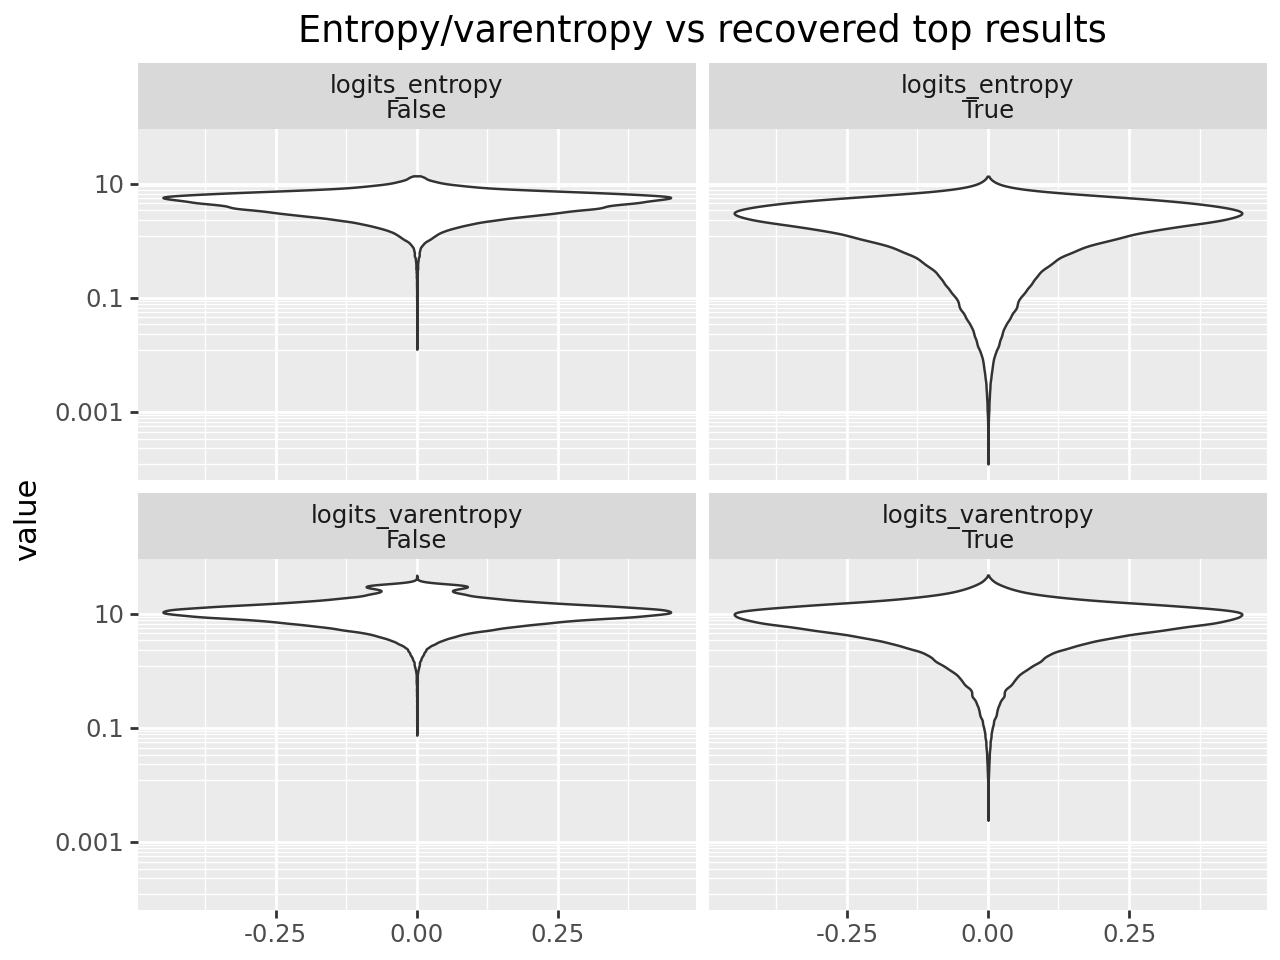

In [76]:
(
  pn.ggplot(
    stats_df.sample(frac=0.1).assign(rank=lambda x: np.clip(x['rank'], 0, 100)).melt(id_vars=["is_best"], value_vars=["logits_entropy", "logits_varentropy"]),
    pn.aes(y="value")
  )
  + pn.facet_wrap("~variable + is_best")
  + pn.scale_y_log10()
  + pn.geom_violin()
  + pn.labs(title="Entropy/varentropy vs recovered top results")
)

/home/hua/code/entropix/.venv/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



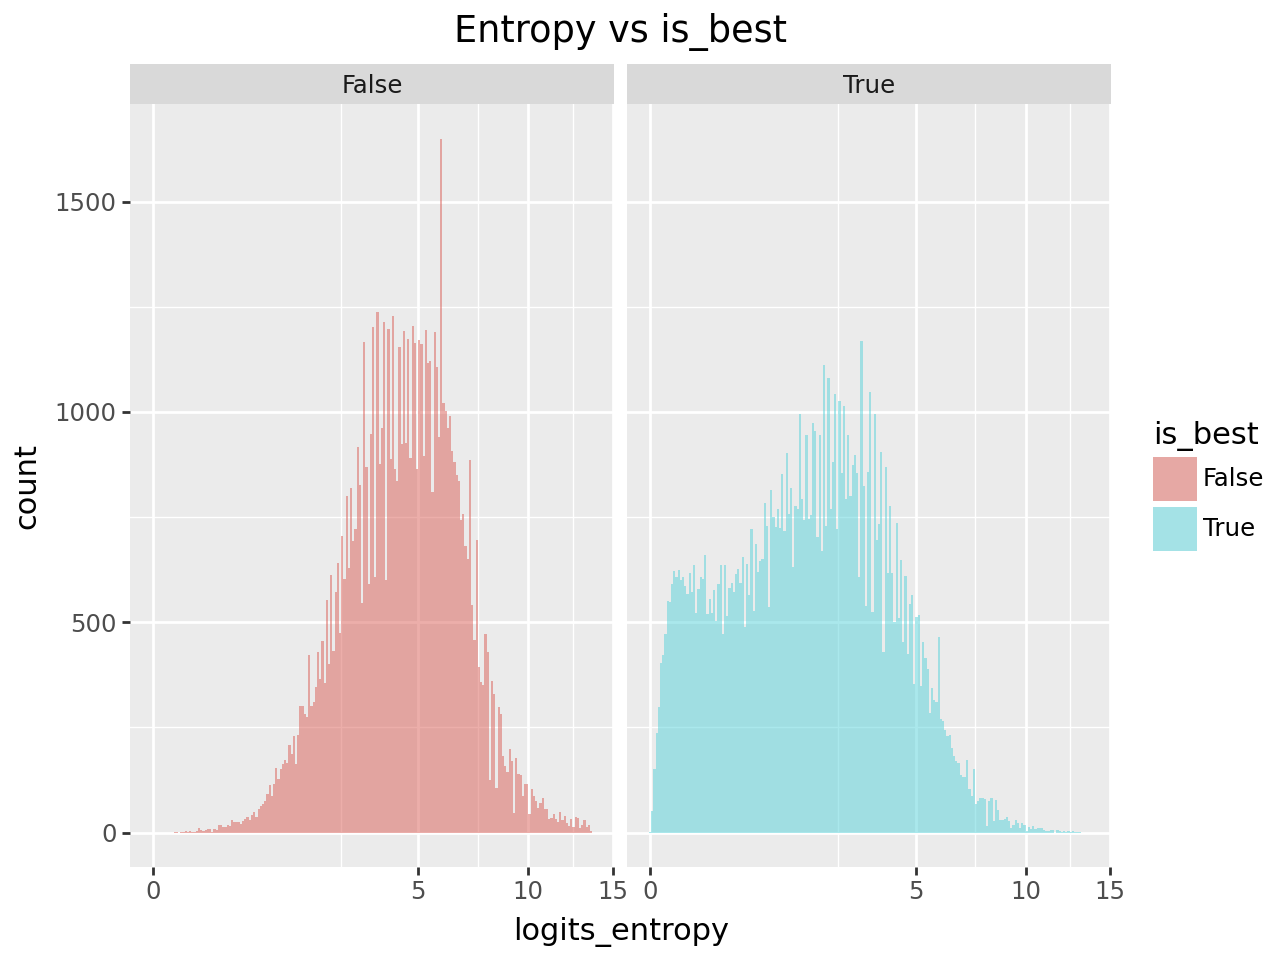

In [87]:
# histogram of entropy vs is_best
(pn.ggplot(
    stats_df.sample(frac=0.1),
    pn.aes(x="logits_entropy", fill="is_best")
) + pn.geom_histogram(bins=200, alpha=0.5) + pn.scale_x_log10() + pn.labs(title="Entropy vs is_best")) + pn.facet_wrap("~is_best") + pn.scale_x_sqrt()


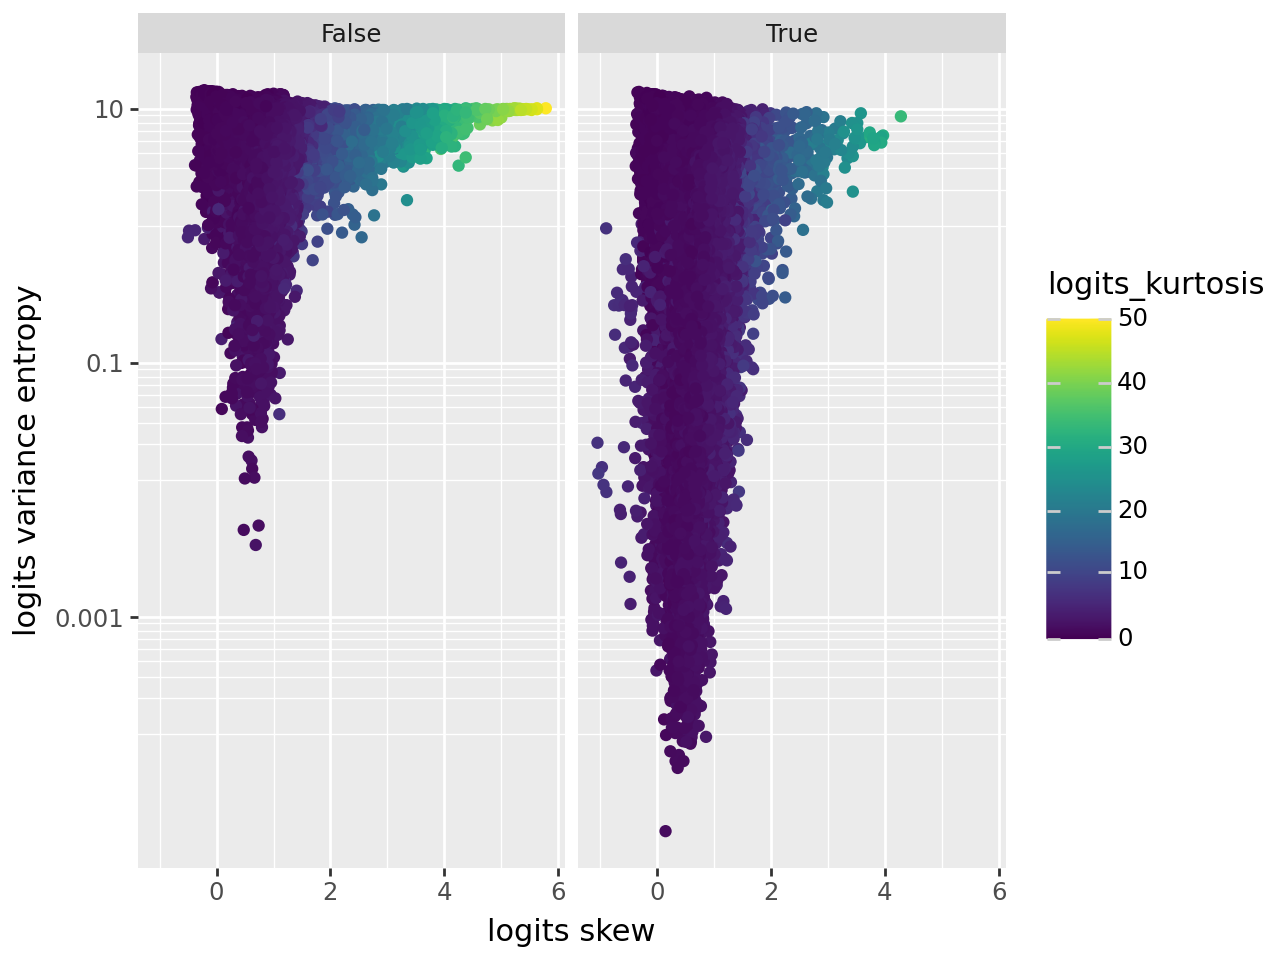

In [60]:
(
  pn.ggplot(
    stats_df, pn.aes(x="logits_skewness", y="logits_entropy", color="logits_kurtosis")
  )
  + pn.geom_point()
    + pn.scale_y_log10()
    + pn.facet_wrap("~is_best")
  + pn.labs(x="logits skew", y="logits variance entropy", color="logits_kurtosis")
)

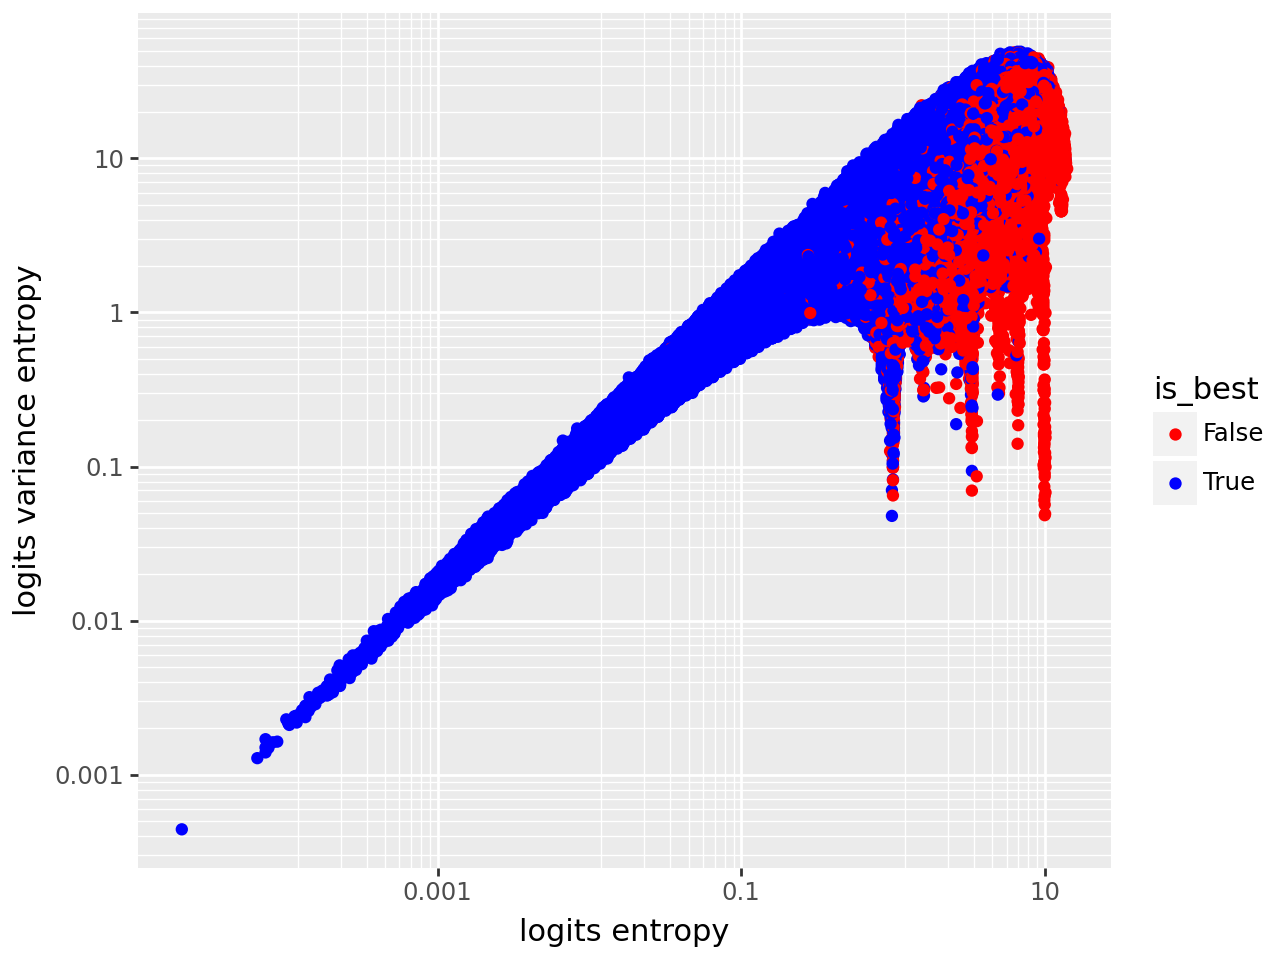

In [26]:
(
  pn.ggplot(
    stats_df, pn.aes(x="logits_entropy", y="logits_varentropy", color="factor(rank==0)")
  )
  + pn.geom_point()
  + pn.scale_x_log10()
    + pn.scale_y_log10()
  + pn.scale_color_manual(values=["red", "blue"])
  + pn.labs(x="logits entropy", y="logits variance entropy", color="is_best")
)

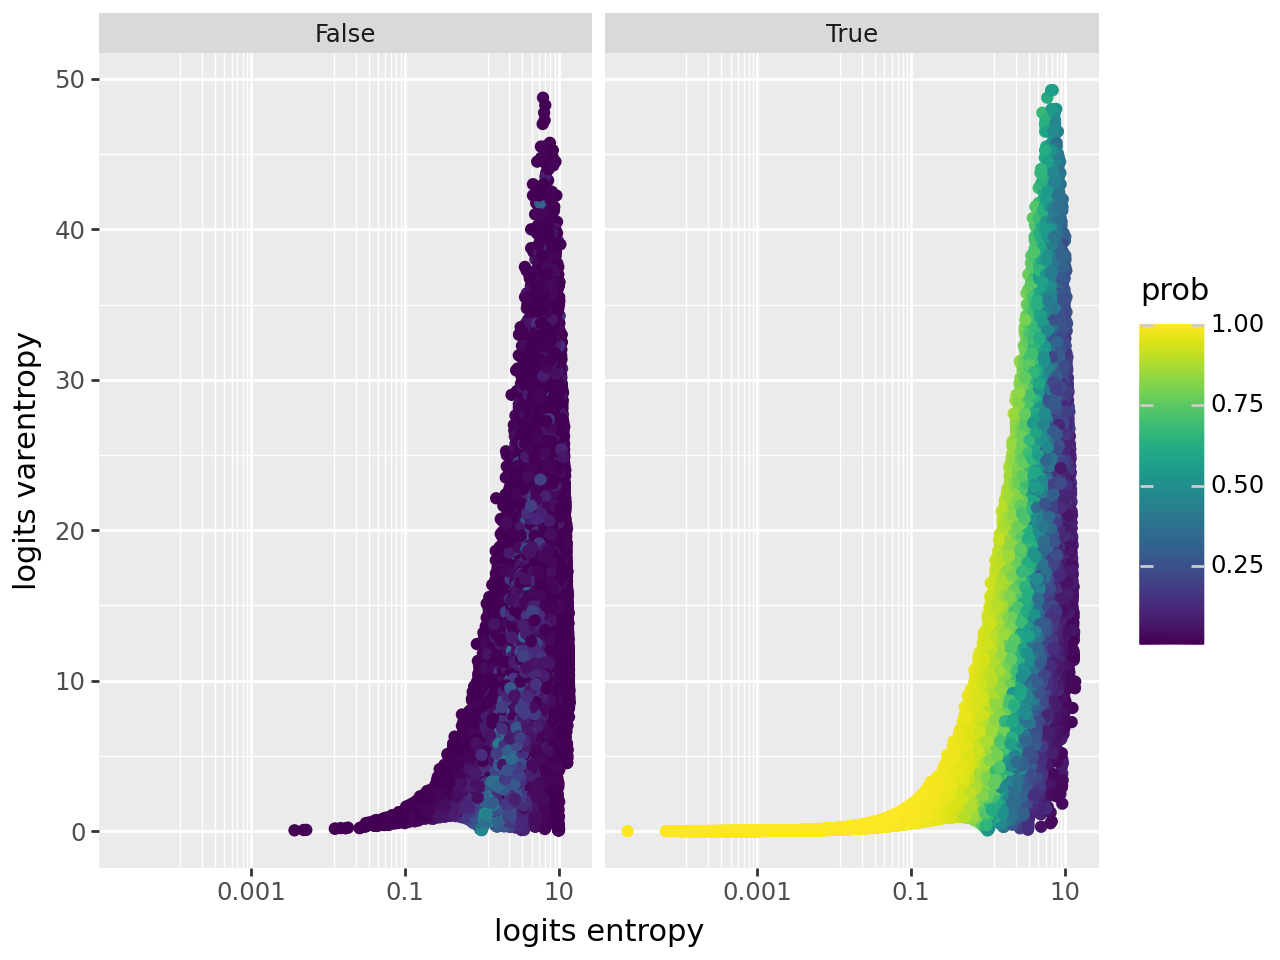

In [118]:
# plot probability of being best vs entropy

(
    pn.ggplot(
        stats_df, pn.aes(x="logits_entropy", y="logits_varentropy", color="prob")
    )
    + pn.geom_point()
    + pn.scale_x_log10()
    + pn.labs(x="logits entropy", y="logits varentropy")
    + pn.facet_wrap("~is_best")
    )


In [115]:
    (stats_df.assign(
        threshold=lambda x: (
            (x['prob'] > 0.15)
        ),
        top1=lambda x: x['rank'] == 0
    )
    .groupby('threshold')
    .agg({'top1': ['mean', 'count', 'sum']})
    )

top1                 
               mean    count     sum
threshold                           
False      0.034599   617962   21381
True       0.856493  1024302  877308

In [147]:
# train a model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


X = stats_df[["normalized_varent", "logits_entropy"]]
# X['logits_entropy'] = X['logits_entropy'].apply(lambda x: np.clip(x, 0, 5))
X['normalized_varent'] = X['normalized_varent'].apply(lambda x: np.clip(x, -5, 5))
# X = stats_df[["logits_entropy", "logits_varentropy", "prob"]]
y = stats_df["rank"] == 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# clf = DecisionTreeClassifier(max_depth=3)
clf = LogisticRegression()
clf.fit(X_train, y_train)

try:
    print(clf.coef_, clf.intercept_)
except:
    pass
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# # print tree splits in text
try:
    print(export_text(clf, feature_names=[ "normalized_varent", "prob",]))
except:
    pass



/tmp/ipykernel_12341/1365028656.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[-0.02603667 -0.61160653]] [2.24811508]
0.7305571752271436
[[161872  83842]
 [ 62182 234052]]
              precision    recall  f1-score   support

       False       0.72      0.66      0.69    245714
        True       0.74      0.79      0.76    296234

    accuracy                           0.73    541948
   macro avg       0.73      0.72      0.73    541948
weighted avg       0.73      0.73      0.73    541948

